Preparing the data

In [ ]:
# Code from Tensorflow Time Series Forecasting tutorial is used throughout this code
# Credit: https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
# Imports and mounting gdrive

from sklearn.preprocessing import MinMaxScaler
import IPython
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MAX_EPOCHS = 2000

# Load the training data

training_data_path = '/content/drive/MyDrive/trainingset_snapshots.csv'
df_training = pd.read_csv(training_data_path)
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372299 entries, 0 to 2372298
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   2024-02-09 00:35:05  object 
 1   60                   int64  
 2   2428.3               float64
 3   17.95993714          float64
 4   49_ask               object 
dtypes: float64(2), int64(1), object(2)
memory usage: 90.5+ MB


In [ ]:
# Load the extra data we will use to test it later
test_data_path = '/content/drive/My Drive/test_orderbook_snapshots.csv'
df_testing = pd.read_csv(test_data_path)
df_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   2024-01-29 16:50:52  28821 non-null  object 
 1   1                    28821 non-null  int64  
 2   2295.2               28821 non-null  float64
 3   4.887505             28821 non-null  float64
 4   0_ask                28821 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
# Reformat and write data to new csv
output_filename = '/content/drive/My Drive/trial_reformatted.csv'

# Initialise a dictionary to hold the data in correct order
orders = defaultdict(lambda: {'Timestamp': None, 'Price': None, 'Quantity': None, 'Order_Type': None})

i = 0
with open(training_data_path, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        timestamp, _, price, quantity, order_type = row
        if order_type.find("bid") == -1:
            #print("Ask value!")
            orders[i]['Order_Type'] = 'A'
            orders[i]['Timestamp'] = timestamp
            orders[i]['Quantity'] = quantity
            orders[i]['Price'] = price
        else:
            #print("Bid value!")
            orders[i]['Order_Type'] = 'B'
            orders[i]['Timestamp'] = timestamp
            orders[i]['Quantity'] = quantity
            orders[i]['Price'] = price
        i = i + 1


# Write the data to a new csv file
with open(output_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Price', 'Quantity', 'Order_Type'])
    for timestamp, order in orders.items():
        writer.writerow([order['Timestamp'], order['Price'], order['Quantity'], order['Order_Type']])


data_path = output_filename
columns = ['Timestamp', 'Price', 'Quantity', 'Order_Type']
data = pd.read_csv(data_path, header=None, names=columns, skiprows=1)


In [ ]:
data

,Timestamp,Price,Quantity,Order_Type
0,2024-02-09 00:35:05,2428.3,17.959937,A
1,2024-02-09 00:35:05,2428.2,1.575000,A
2,2024-02-09 00:35:05,2427.9,56.256254,A
3,2024-02-09 00:35:05,2427.8,3.765601,A
4,2024-02-09 00:35:05,2427.5,1.594140,A
...,...,...,...,...
2372295,2024-02-09 08:51:37,2462.2,0.040592,B
2372296,2024-02-09 08:51:37,2462.1,4.421087,B
2372297,2024-02-09 08:51:37,2462.0,10.000000,B
2372298,2024-02-09 08:51:37,2461.9,1.883993,B


In [ ]:
# Stats on the code
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2372300.0,2445.053899,12.707116,2.413900e+03,2436.000000,2448.500000,2454.000000,2473.300000
Quantity,2372300.0,18.238484,29.336916,1.000000e-08,1.650606,5.380902,22.046542,858.995494


In [ ]:
orders = data

# Convert timestamp to a numerical format
orders['Timestamp'] = pd.to_datetime(orders['Timestamp'], format='%Y.%m.%d %H:%M:%S')

# Normalize the dataset
scaler = MinMaxScaler()
orders[['Price', 'Quantity']] = \
  scaler.fit_transform(orders[['Price', 'Quantity']])

date_time = orders.pop('Timestamp')

orders['Timestamp'] = date_time.map(pd.Timestamp.timestamp)

orders.head()

,Price,Quantity,Order_Type,Timestamp
0,0.242424,0.020908,A,1.707439e+09
1,0.240741,0.001834,A,1.707439e+09
2,0.235690,0.065491,A,1.707439e+09
3,0.234007,0.004384,A,1.707439e+09
4,0.228956,0.001856,A,1.707439e+09


In [ ]:
print("total bid orders: ", orders[orders['Order_Type'] == 'B']['Order_Type'].count())
print("total ask orders: ", orders[orders['Order_Type'] == 'A']['Order_Type'].count())


total bid orders:  1186150
total ask orders:  1186150


In [ ]:
md_trades = orders

md_trades['price_asks'] = orders.loc[orders['Order_Type'] == 'A', 'Price']
md_trades['price_bids'] = orders.loc[orders['Order_Type'] == 'B', 'Price']

md_trades = md_trades.groupby('Timestamp').agg({'price_bids':max, 'price_asks':min})

md_trades['MidPrice'] = 0
for row in md_trades.index:
  md_trades.loc[row, 'MidPrice'] = (md_trades.loc[row, 'price_bids'] + md_trades.loc[row, 'price_asks'])/2

md_trades.head()

#mid_traded = md_trades.drop_duplicates('Timestamp', keep='first').MidPrice.get_values().tolist()[:-1] #:-1 to exclude the last row with nans
#len(mid_traded)


,price_bids,price_asks,MidPrice
Timestamp,,,
1.707439e+09,0.141414,0.143098,0.142256
1.707439e+09,0.141414,0.143098,0.142256
1.707439e+09,0.141414,0.143098,0.142256
1.707439e+09,0.139731,0.143098,0.141414
1.707439e+09,0.139731,0.143098,0.141414


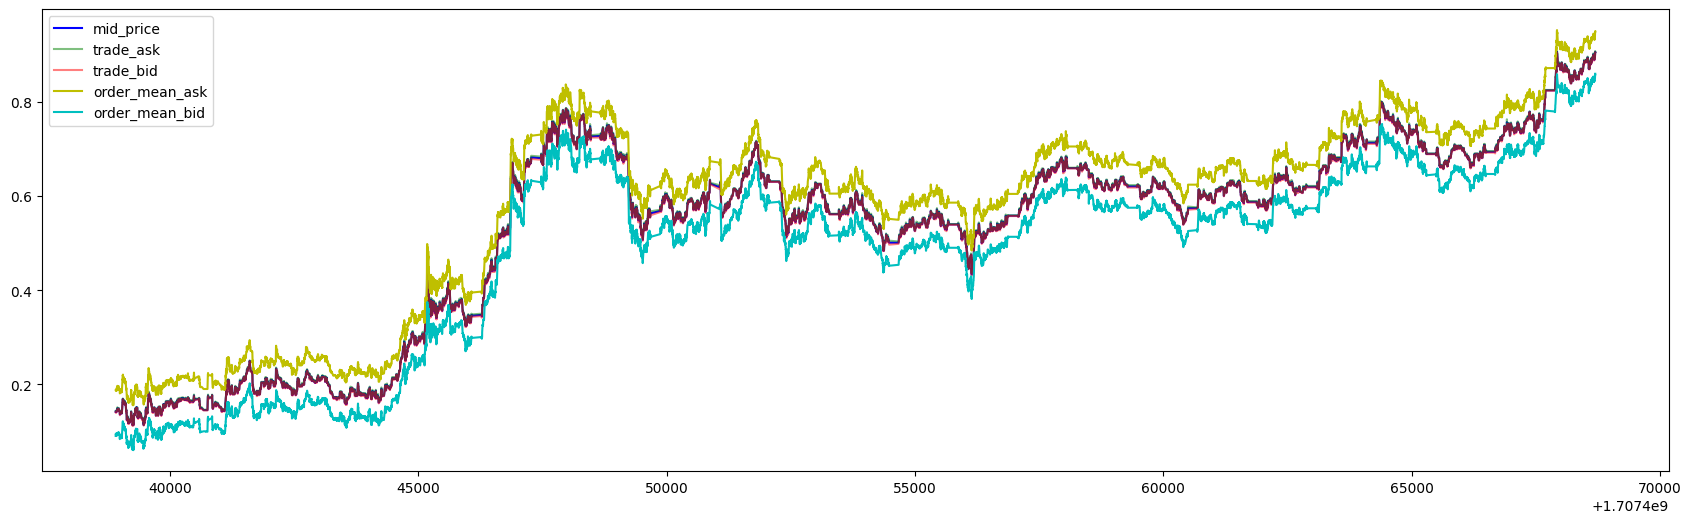

In [ ]:
bid_order = orders[orders['Order_Type']=='B'][['Timestamp','Price']]
ask_order = orders[orders['Order_Type']=='A'][['Timestamp','Price']]

#mean ask order and mean bid order per timestamp
mn_bid_orders = bid_order.groupby('Timestamp').agg({'Price':pd.Series.mean})
mn_ask_orders = ask_order.groupby('Timestamp').agg({'Price':pd.Series.mean})

plt.figure(figsize=(21,6))
plt.plot(md_trades.MidPrice, color='b', label='mid_price')
plt.plot(md_trades.price_asks, color='g', alpha=0.5, label='trade_ask')
plt.plot(md_trades.price_bids, color='r', alpha=0.5, label='trade_bid')
plt.plot(mn_ask_orders.Price, color='y', label='order_mean_ask')
plt.plot(mn_bid_orders.Price, color='c', label='order_mean_bid')
plt.legend()


In [ ]:
y = pd.DataFrame(md_trades.MidPrice)
y.reset_index(inplace=True)

train_df = orders.merge(y, on='Timestamp', how='outer')

train_df = train_df.drop(columns=['price_asks', 'price_bids'])

train_df

,Price,Quantity,Order_Type,Timestamp,MidPrice
0,0.242424,0.020908,A,1.707439e+09,0.142256
1,0.240741,0.001834,A,1.707439e+09,0.142256
2,0.235690,0.065491,A,1.707439e+09,0.142256
3,0.234007,0.004384,A,1.707439e+09,0.142256
4,0.228956,0.001856,A,1.707439e+09,0.142256
...,...,...,...,...,...
2372295,0.813131,0.000047,B,1.707469e+09,0.904882
2372296,0.811448,0.005147,B,1.707469e+09,0.904882
2372297,0.809764,0.011642,B,1.707469e+09,0.904882
2372298,0.808081,0.002193,B,1.707469e+09,0.904882


Tensorflow Keras LSTM Model method

In [ ]:
encoded_df = pd.get_dummies(train_df)

In [ ]:
encoded_df

,Price,Quantity,Timestamp,MidPrice,Order_Type_A,Order_Type_B
0,0.242424,0.020908,1.707439e+09,0.142256,1,0
1,0.240741,0.001834,1.707439e+09,0.142256,1,0
2,0.235690,0.065491,1.707439e+09,0.142256,1,0
3,0.234007,0.004384,1.707439e+09,0.142256,1,0
4,0.228956,0.001856,1.707439e+09,0.142256,1,0
...,...,...,...,...,...,...
2372295,0.813131,0.000047,1.707469e+09,0.904882,0,1
2372296,0.811448,0.005147,1.707469e+09,0.904882,0,1
2372297,0.809764,0.011642,1.707469e+09,0.904882,0,1
2372298,0.808081,0.002193,1.707469e+09,0.904882,0,1


In [ ]:
column_indices = {name: i for i, name in enumerate(encoded_df.columns)}

n = len(encoded_df)
train = encoded_df[0:int(n*0.7)]
val_df = encoded_df[int(n*0.7):int(n*0.9)]
test_df = encoded_df[int(n*0.9):]

num_features = encoded_df.shape[1]

train.head()

,Price,Quantity,Timestamp,MidPrice,Order_Type_A,Order_Type_B
0,0.242424,0.020908,1.707439e+09,0.142256,1,0
1,0.240741,0.001834,1.707439e+09,0.142256,1,0
2,0.235690,0.065491,1.707439e+09,0.142256,1,0
3,0.234007,0.004384,1.707439e+09,0.142256,1,0
4,0.228956,0.001856,1.707439e+09,0.142256,1,0


In [ ]:
train_df = train

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
              train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='Price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result

  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Price'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Price']

In [ ]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
MAX_EPOCHS = 200

# Recurrent Neural Network - LSTM
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

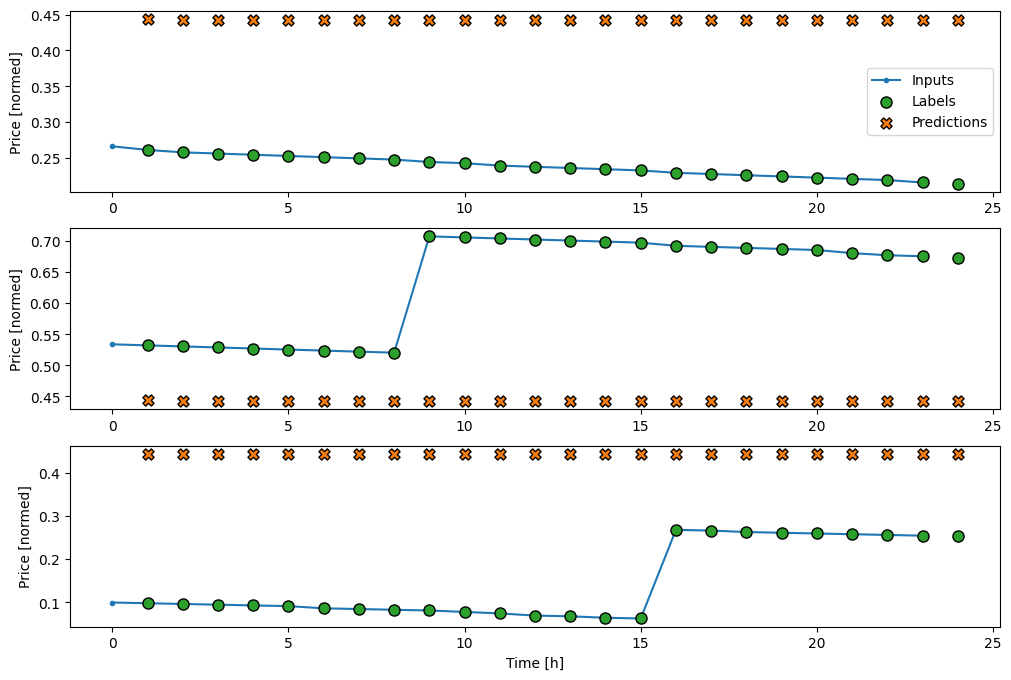

In [ ]:
wide_window.plot(lstm_model)

Github Method:

In [ ]:
def orders_by_type(orders, order_type):
  return orders[orders['Order_Type'] == order_type].set_index('Timestamp')[['Price', 'Quantity']]


buys = orders_by_type(train_df, 'B')

sells = orders_by_type(train_df, 'A')


KeyError: 'Order_Type'

In [ ]:
buys_dict = buys.groupby(level=0).apply(lambda x: x.set_index('Price').squeeze().to_dict()).to_dict()

sells_dict = sells.groupby(level='Timestamp').apply(lambda x: x.set_index('Price').squeeze().to_dict()).to_dict()


In [ ]:
#changing each of the above dicts to a list of lists, where data for each time step is stored as a list of (price, vol) pairs
def price_vol(orders_dict):

  pri_vol = []
  for k, v in orders_dict.items():
    pri_vol.append(list(v.items()))

  return pri_vol

print("Length of buy lists: {}, sell lists: {}".format(len(price_vol(buys_dict)), len(price_vol(sells_dict))))


In [ ]:
b_times = buys.index.unique()
s_times = sells.index.unique()

buys_list = [] #a list of arrays where each array is the sorted buy prices per timestamp
sells_list = [] #a list of arrays where each array is the sorted sell prices per timestamp

b_ts = list(b_times)
s_ts = list(s_times)

for ind in b_ts:
  buys_list.append(buys.loc[ind, 'Price'].values)

for ind in s_ts:
  sells_list.append(sells.loc[ind, 'Price'].values)

buys_list.insert(23723, []) #adding an empty list at index 2193 to buys

mid_traded = train_df.drop_duplicates('Timestamp', keep='first')
mid_traded = mid_traded['MidPrice'].tolist()

buys_mid_traded = mid_traded.copy()
len(mid_traded), len(buys_mid_traded)


In [ ]:
plt.figure(figsize=(20,10))
s = 2190 #index to start from (remember index 2193 only has sells)
for i in range(30):
  plt.subplot(3,10,i+1) #ax number should start from 1
  plt.plot(np.linspace(0, 100, num=len(sells_list[i+s])), sells_list[i+s], 'g', label="Sell")
  plt.plot(np.linspace(0, 100, num=len(buys_list[i+s])), buys_list[i+s], 'r', label="Buy")
  plt.plot(np.linspace(0, 100, num=len(sells_list[i+s])), [mid_traded[i+s] for _ in range(len(sells_list[i+s]))])
  plt.ylabel('Price')
  plt.legend()

In [ ]:
# Plot to show the bid/ask prices within the span of 2 hours - 5.5 minute timesteps

In [ ]:
def n_one_side_of_mid_to_wing(prix_vol, mid_price, n, order_type):
  '''
  Appends the mid traded price of each timestamp to its price_vol list, sorts it and returns n number of orders either side of the Mid traded price for
  that time stamp. If there was less than n orders either side of the mid trade price, it will generate fake (price, 0 vol) orders form the last seen price.
  '''
  length_before = len(prix_vol)        #lenght before appending the mid trade price
  prix_vol.append((mid_price, 0))      #append (mid trade price, 0 vol) to prix_vol list
  length_after = len(prix_vol)         #lenght after appending the mid trade price
  prix_vol = sorted(prix_vol)          #sort by price
  idx = prix_vol.index((mid_price, 0)) #index of the mid trade price

  #print(prix_vol)
  #print(idx, mid_price)

  #mid price smaller than all other prices and we have enough orders to cover n samples [mid, 0.6, 0.7, 0.9, ...]
  if idx == 0 and length_before >= n:
    ll = [prix_vol[i] for i in range(1, n+1)] #n of the smallest price (index 1) + index 1 to last price

  #mid price smaller than all other prices and there isnt enough orders to cover n [mid, 0.6, 0.7, 0.9]
  elif idx == 0 and length_before < n:
    diff = (prix_vol[-1][0] - prix_vol[-2][0])/2 #diff of the two largest prices at the wing divided by 2. below *i is to get different prices rather than same thing
    ll = [prix_vol[i] for i in range(1, len(prix_vol))] + [(prix_vol[-1][0] + diff*i, 0) for i in range(1, n-length_before+1)]

  #mid price larger than all other prices and enough samples to cover n [..., 0.4, 0.44, 0.6, mid]
  elif idx == length_after-1 and length_before >= n:
    ll = [prix_vol[i] for i in range(-n-1, -1)]

  #mid price larger than all other prices and there isnt enough orders to cover n [0.4, 0.44, 0.6, mid]
  elif idx == length_after-1 and length_before < n:
    diff = (prix_vol[1][0] - prix_vol[0][0])/2 #diff of the first two (smallest) prices. below /i to avoid going below zero
    ll = [(prix_vol[0][0] - diff/i, 0) for i in range(1, n-length_before+1)] + [prix_vol[i] for i in range(0, len(prix_vol)-1)]

  else: #mid price falls in between other orders
    if order_type == 'S': #take the values smaller than mid
      if idx >= n:
        ll = [prix_vol[i] for i in range(idx-n, idx)]
      else:
        diff = (prix_vol[1][0] - prix_vol[0][0])/2
        ll = [(prix_vol[0][0] - diff/i, 0) if i < 0 else prix_vol[i] for i in range(idx-n, idx)]

    if order_type == 'B': #take values larger than mid
      if length_after-idx > n:
        ll = [prix_vol[i] for i in range(idx+1, idx+n+1)]
      else:
        diff = (prix_vol[-1][0] - prix_vol[-2][0])/2
        ll = [prix_vol[i] for i in range(idx+1, length_after)] + [(prix_vol[-1][0] + diff*i, 0) for i in range(1, n-(length_after-idx-1)+1)]

  return [l_1 for l2 in ll for l_1 in l2] #change the list of (price, vol) tuples to a flat list of [price, vol, price, vol, ...]

def all_orders_around_mid(pri_vol_lists, mid_list, n, order_type):
  price_vols = []
  for i in range(len(pri_vol_lists)):
    price_vols.append(n_one_side_of_mid_to_wing(pri_vol_lists[i], mid_list[i], n, order_type))
  return price_vols

In [ ]:
ts = train_df.Timestamp.unique().tolist()

buy_orders = price_vol(buys_dict)
buy_orders = all_orders_around_mid(buy_orders, buys_mid_traded, 20, 'B')
buy_orders.insert(23723, [0]*40) #adding a list with length 40 to index 2193, to make buys and sells same length

sell_orders = price_vol(sells_dict)
sell_orders = all_orders_around_mid(sell_orders, mid_traded, 20, 'S')

for i in range(len(buy_orders)-1):
  buy_orders[i].extend(sell_orders[i])

print(buy_orders[1001])

cols = [["B_P"+str(i+1)]+["B_V"+str(i+1)] for i in range(20)] + [["S_P"+str(i+1)]+["S_V"+str(i+1)] for i in range(20)]
columns = [c for cc in cols for c in cc]

data_dict = {ts[i]:buy_orders[i] for i in range(len(ts))}
train_df_80 = pd.DataFrame.from_dict(data_dict, orient='index')
train_df_80.columns = columns
train_df_80['Mid'] = mid_traded

pd.set_option('display.max_columns', 81)
train_df_80


In [ ]:
train_df_80.to_csv('/content/drive/My Drive/train_df_80.csv')

In [ ]:
from sklearn.pipeline import Pipeline

def train_test_split(X, y, start=0, ratio=0.2):

  samples = int(X[start:].shape[0] * (1 - ratio))
  idx_to = start + samples

  X_train = X[start:idx_to, :]
  y_train = y[start:idx_to, :]
  X_test = X[idx_to:, :]
  y_test = y[idx_to:, :]

  return X_train, y_train, X_test, y_test

def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

#function to transform 3d batches to 2d
def _3d_to_2d(arr):
    return arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2])

pipeline = Pipeline(steps=[('scaler', MinMaxScaler())])
X_y = pipeline.fit_transform(train_df_80.values)
print(X_y.shape)

In [ ]:
X = X_y[:-1000,:-1]
y = np.expand_dims(X_y[:-1000,-1], axis=1)
X_train, y_train, X_test, y_test = train_test_split(X, y)
print(len(X_train), len(y_train), len(X_test), len(y_test))

In [ ]:
#Batch size is important, any dependencies further apart from the Batch_size will not be taken into account. We could in theory give only one batch
#with the entire sequence but that will take an excessive amount of time to train and also the success is not guaranteed (vanishing gradient problem).

batch_size = 30 #30 is about 165 minute (5.5min per ts x 30), tried 15 and a few other values too but 30 seems to be the best

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)


In [ ]:
train_df_80

In [ ]:
inputs = tf.keras.Input(shape=(None, 80))

lstm = LSTM(32, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False)(inputs)

#output layer
predictions = TimeDistributed(Dense(1, activation='linear'))(lstm)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='mean_absolute_error',
              metrics=['mean_squared_error'])



In [ ]:
model.fit(X_train_batch, y_train_batch, epochs=500)

In [ ]:
y_test.shape

In [ ]:
y_pred = model.predict(X_test_batch)

print(y_pred.shape)

print(mean_absolute_error(y_test, _3d_to_2d(y_pred)[:4545]))
print(mean_squared_error(y_test, _3d_to_2d(y_pred)[:4545]))

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, _3d_to_2d(y_pred)[:4545], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')


In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test)), y_test, label='Actual')
plt.plot(np.linspace(0, 100, len(y_test)), _3d_to_2d(y_pred)[:4545], alpha=0.6, label='Predicted')
plt.legend()


In [ ]:
md_trades = orders.groupby('Timestamp')
md_trades = md_trades.agg({'best_bid_price': max, 'best_ask_price':min})
md_trades['MidPrice'] = 0
for row in md_trades.index:
  md_trades.loc[row, 'MidPrice'] = (md_trades.loc[row, 'best_bid_price'] + md_trades.loc[row, 'best_ask_price'])/2

md_trades.head()

In [ ]:
bid_order = orders[['timestamp','best_bid_price']]
ask_order = orders[['timestamp','best_ask_price']]

#mean ask order and mean bid order per timestamp
mn_bid_orders = bid_order.groupby('timestamp').agg({'best_bid_price':pd.Series.mean})
mn_ask_orders = ask_order.groupby('timestamp').agg({'best_ask_price':pd.Series.mean})

plt.figure(figsize=(21,6))
plt.plot(md_trades.MidPrice, color='b', label='mid_price')
plt.plot(orders.set_index('timestamp').best_ask_qty, color='g', alpha=0.5, label='trade_ask')
plt.plot(orders.set_index('timestamp').best_bid_qty, color='r', alpha=0.5, label='trade_bid')
plt.plot(mn_ask_orders.best_ask_price, color='y', label='order_mean_ask')
plt.plot(mn_bid_orders.best_bid_price, color='c', label='order_mean_bid')
plt.legend()

mn_bid_orders.head()

In [ ]:
# Creating a dataframe with mid trade prices, then merge with order book data to be used for training

y = pd.DataFrame(md_trades.MidPrice)
y.reset_index(inplace=True)

train_df = orders.merge(y, on='timestamp', how='outer')

train_df.to_csv('/content/drive/My Drive/train_df.csv', index=False)


In [ ]:
train_df

In [ ]:
mid_traded = train_df.drop_duplicates('timestamp', keep='first').MidTraded.get_values().tolist()[:-1] #:-1 to exclude the last row with nans
